In [2]:
import os
from pathlib import Path

folder = "Anaconda/Baram"
project_dir = "MaskClassificaion"

base_path = Path("/Users/yuchul/")
project_path = base_path / folder / project_dir
os.chdir(project_path)
for x in list(project_path.glob("*")):
    if x.is_dir():
        dir_name = str(x.relative_to(project_path))
        os.rename(dir_name, dir_name.split(" ", 1)[0])
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: /Users/yuchul/Anaconda/Baram/MaskClassificaion


In [3]:
import torch 
print('pytorch version: {}'.format(torch.__version__))

pytorch version: 1.12.1


In [4]:
import numpy as np
import torchvision
import glob
import sys, os
sys.path.append(os.pardir) # 부모 디렉토리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from collections import OrderedDict
import pickle
import torch
%matplotlib inline
import cv2
from imutils.video import VideoStream
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

print('GPU 사용 가능 여부: {}'.format(torch.cuda.is_available()))
device = "cuda" if torch.cuda.is_available() else "CPU"

GPU 사용 가능 여부: False


In [5]:
current_path = Path().absolute()
data_path = current_path / "data_old"
print("현재 디렉토리 위치: {}".format(current_path))
if (data_path / "mask_cnn").exists():
    print("이미 'data/mask_cnn' 폴더가 있습니다! 이어서 진행하세요~")
else: print("없습니다")

현재 디렉토리 위치: /Users/yuchul/Anaconda/Baram/MaskClassificaion
이미 'data/mask_cnn' 폴더가 있습니다! 이어서 진행하세요~


In [6]:
data_dir = './data_old/mask_cnn'

In [7]:
batch_size = 100
num_epochs = 30
learning_rate = 0.0001

In [8]:
data_path

PosixPath('/Users/yuchul/Anaconda/Baram/MaskClassificaion/data_old')

In [9]:
class MaskNonMaskDataset(Dataset):
    def __init__(self, data_dir, mode, transform=None, train_size=None):
        
        self.all_data = sorted(glob.glob(os.path.join(data_dir, mode, '*', '*')))
        
        #RGB 가 아닌 파일필터링
#         self.all_data = [i for i in self.old_all_data if transform(Image.open(i)).shape[0] == 3]
    
        
        self.mode = mode
        self.transform = transform
        self.train_size = 4600
    
    def __getitem__(self, index):
        data_path = self.all_data[index]
        img = Image.open(data_path)
        if self.transform != None:
            img = self.transform(img)
        
        if os.path.basename(data_path).startswith("Mask"):
            label = 0
        else:
            label = 1
        return img, label
    
    def __len__(self):
        length = len(self.all_data)
        return length

In [10]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val' : transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        # transforms.Normalize([0.485,  0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# train_data = MaskNonMaskDataset(data_dir='./data/mask_cnn', mode='Train', transform=data_transforms['train'])
# val_data = MaskNonMaskDataset(data_dir='./data/mask_cnn', mode='Validation', transform=data_transforms['val'])
# test_data = MaskNonMaskDataset(data_dir='./data/mask_cnn', mode='Test', transform=data_transforms['val'])

# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
# val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [11]:
for num, value in enumerate(train_data):
    data, label = value
    print(num, data, label)
    
    imshow(data)
    break

NameError: name 'train_data' is not defined

In [17]:
train_data = torchvision.datasets.ImageFolder(root='./data_old/mask_cnn/Train', transform=data_transforms['train'])
val_data = torchvision.datasets.ImageFolder(root='./data_old/mask_cnn/Validation', transform=data_transforms['val'])
test_data = torchvision.datasets.ImageFolder(root='./data_old/mask_cnn/Test', transform=data_transforms['val'])

In [18]:
temp = glob.glob(os.path.join(data_dir, "train", '*', '*'))
len(temp)

8149

In [19]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [20]:
class VGG6(nn.Module):
    def __init__(self):
        super().__init__()
        # self.conv 구현
        self.conv = nn.Sequential(
            ## 코드 시작 ##
            nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1),    
            nn.BatchNorm2d(32),                                      
            nn.ReLU(),                                               
                                                 
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),   
            nn.BatchNorm2d(64),                                      
            nn.ReLU(),                                               
            nn.MaxPool2d(2),                                         
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  
            nn.BatchNorm2d(128),                                     
            nn.ReLU(),                                                                                      
            
            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(128),                                     
            nn.ReLU(),                                               
            nn.MaxPool2d(2),                                         

        )
        
        self.fc1 = torch.nn.Linear(6272, 512)
        self.fc2 = torch.nn.Linear(512,2)
    
    def forward(self, x):
        x = self.conv(x)
        print(x.shape)
        x = x.view(x.shape[0], -1)
        print(x.shape)
        x = F.relu(self.fc1(x))
        print(x.shape)
        x = self.fc2(x)
        print(x.shape)
        return x

In [21]:
input = torch.randn((3,3,224,224))
model = VGG6()
output = model(input)
print(output.shape)

torch.Size([3, 128, 7, 7])
torch.Size([3, 6272])
torch.Size([3, 512])
torch.Size([3, 2])
torch.Size([3, 2])


In [22]:
def train(num_epochs, model, data_loader, criterion, optimizer, saved_dir, val_every, device):
    print('Start training..')
    best_loss = 9999999
    for epoch in range(num_epochs):
        for i, (imgs, labels) in enumerate(data_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, argmax = torch.max(outputs, 1)
            accuracy = (labels == argmax).float().mean()

            if (i+1) % 3 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
                    epoch+1, num_epochs, i+1, len(data_loader), loss.item(), accuracy.item() * 100))

        if (epoch + 1) % val_every == 0:
            avrg_loss = validation(epoch + 1, model, val_loader, criterion, device)
            if avrg_loss < best_loss:
                print('Best performance at epoch: {}'.format(epoch + 1))
                print('Save model in', saved_dir)
                best_loss = avrg_loss
                save_model(model, saved_dir)

In [23]:
def validation(epoch, model, data_loader, criterion, device):
    print('Start validation #{}'.format(epoch) )
    model.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        total_loss = 0
        cnt = 0
        for i, (imgs, labels) in enumerate(data_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            ## 코드 시작 ##
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            ## 코드 종료 ##
            total += imgs.size(0)
            _, argmax = torch.max(outputs, 1)
            correct += (labels == argmax).sum().item()
            total_loss += loss
            cnt += 1
        avrg_loss = total_loss / cnt
        print('Validation #{}  Accuracy: {:.2f}%  Average Loss: {:.4f}'.format(epoch, correct / total * 100, avrg_loss))
    model.train()
    return avrg_loss

In [24]:
def test(model, data_loader, device):
    print('Start test..')
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (imgs, labels) in enumerate(data_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            ## 코드 시작 ##
            outputs = model(imgs)
            ## 코드 종료 ##
            _, argmax = torch.max(outputs, 1)    # max()를 통해 최종 출력이 가장 높은 class 선택
            total += imgs.size(0)
            correct += (labels == argmax).sum().item()

        print('Test accuracy for {} images: {:.2f}%'.format(total, correct / total * 100))
    model.train()

In [25]:
def save_model(model, saved_dir, file_name='best_model.pt'):
    os.makedirs(saved_dir, exist_ok=True)
    check_point = {
        'net': model.state_dict()
    }
    output_path = os.path.join(saved_dir, file_name)
    torch.save(check_point, output_path)

In [26]:
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

device = torch.device(device)

In [27]:
torch.manual_seed(7777)

model = VGG6().to(device)
model = model.to(device)

criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

model = model.to(device)
val_every = 1
saved_dir = './saved/VGG6_torch'

In [ ]:
# train(num_epochs, model, train_loader, criterion, optimizer, saved_dir, val_every, device)

In [28]:
model_path = './saved/VGG6_torch/best_model.pt'
model = VGG6().to(device)

check_point = torch.load(model_path, map_location=device)
state_dict = check_point['net']
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
test(model, test_loader, device)

torch.Size([1, 128, 7, 7])
torch.Size([1, 6272])
torch.Size([1, 512])
torch.Size([1, 2])
torch.Size([1, 128, 7, 7])
torch.Size([1, 6272])
torch.Size([1, 512])
torch.Size([1, 2])
torch.Size([1, 128, 7, 7])
torch.Size([1, 6272])
torch.Size([1, 512])
torch.Size([1, 2])
torch.Size([1, 128, 7, 7])
torch.Size([1, 6272])
torch.Size([1, 512])
torch.Size([1, 2])
torch.Size([1, 128, 7, 7])
torch.Size([1, 6272])
torch.Size([1, 512])
torch.Size([1, 2])
torch.Size([1, 128, 7, 7])
torch.Size([1, 6272])
torch.Size([1, 512])
torch.Size([1, 2])
torch.Size([1, 128, 7, 7])
torch.Size([1, 6272])
torch.Size([1, 512])
torch.Size([1, 2])
torch.Size([1, 128, 7, 7])
torch.Size([1, 6272])
torch.Size([1, 512])
torch.Size([1, 2])
torch.Size([1, 128, 7, 7])
torch.Size([1, 6272])
torch.Size([1, 512])
torch.Size([1, 2])
torch.Size([1, 128, 7, 7])
torch.Size([1, 6272])
torch.Size([1, 512])
torch.Size([1, 2])
torch.Size([1, 128, 7, 7])
torch.Size([1, 6272])
torch.Size([1, 512])
torch.Size([1, 2])
torch.Size([1, 128, 7

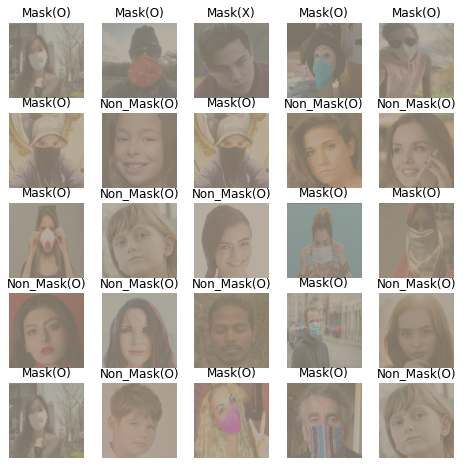

In [29]:
columns = 5
rows = 5
fig = plt.figure(figsize=(8,8))

model.eval()
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device) 
    '''
    unsqueeze()를 통해 입력 이미지의 shape을 (1, 28, 28)에서 (1, 1, 28, 28)로 변환. 
    모델에 들어가는 입력 이미지의 shape은 (batch_size, channel, width, height) 되어야 함에 주의하세요!
    '''
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = argmax.item()
    label = test_data[data_idx][1]
    
    fig.add_subplot(rows, columns, i)
    pred_title = 'Mask' if pred == 0 else 'Non_Mask'
    if pred == label:
        plt.title(pred_title + '(O)')
    else:
        plt.title(pred_title + '(X)')
    plot_img = test_data[data_idx][0]
    # 이미지를 normalization 이전 상태로 되돌리는 작업
    plot_img[0, :, :] = plot_img[0, :, :] * std[0] + mean[0]
    plot_img[1, :, :] = plot_img[1, :, :] * std[1] + mean[1]
    plot_img[2, :, :] = plot_img[2, :, :] * std[2] + mean[2]
    plot_img = transforms.functional.to_pil_image(plot_img)
    plt.imshow(plot_img)
    plt.axis('off')
plt.show()

In [ ]:
import cv2

labels_dict={1:'without_mask',0:'with_mask'}
color_dict={1:(0,0,255),0:(0,255,0)}

size = 4
webcam = cv2.VideoCapture(0) #Use camera 0

# We load the xml file
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

while True:
    (rval, im) = webcam.read()
    im=cv2.flip(im,1,1) #Flip to act as a mirror

    # Resize the image to speed up detection
    mini = cv2.resize(im, (im.shape[1] // size, im.shape[0] // size))

    # detect MultiScale / faces 
    faces = classifier.detectMultiScale(mini)

    # Draw rectangles around each face
    for f in faces:
        (x, y, w, h) = [v * size for v in f] #Scale the shapesize backup
        #Save just the rectangle faces in SubRecFaces
        face_img = im[y:y+h, x:x+w]
        resized=cv2.resize(face_img,(224,224))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,3,224,224))
#         reshaped = np.vstack([reshaped])
        result=model.forward(torch.FloatTensor(reshaped))
#         print(result)
        
        label=torch.argmax(result,dim=1)[0]
        label = label.tolist()
        print(label)
    
        cv2.rectangle(im,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(im,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(im, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    # Show the image
    cv2.imshow('LIVE',   im)
    key = cv2.waitKey(5)
    # if Esc key is press then break out of the loop 
    if key == 27: #The Esc key
        break